In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import defaultdict

# Environment

In [11]:
class GridWorld:
    def __init__(
        self, 
        size=4,
        terminal_states=((0,0), (3,3)), 
        reward=-1
    ):
        self.size = size
        self.terminal_states = terminal_states
        self.reward = reward
        self.actions = ('U', 'D', 'L', 'R')
        self.reset()

    def is_terminal(self, state):
        return state in self.terminal_states
    
    def reset(self):
        self.state = (np.random.randint(self.size), np.random.randint(self.size))
        while self.state in self.terminal_states:
            self.state = (np.random.randint(self.size), np.random.randint(self.size))
        return self.state

    def step(self, action):
        if self.is_terminal(self.state):
            return self.state, 0, True

        x, y = self.state
        if action == 'U': x = max(x - 1, 0)
        if action == 'D': x = min(x + 1, self.size - 1)
        if action == 'L': y = max(y - 1, 0)
        if action == 'R': y = min(y + 1, self.size - 1)
        self.state = (x, y)
        
        return self.state, self.reward, self.is_terminal(self.state)


def uniform_random_policy(state):
    """
    Uniform random policy: returns a random action.
    """
    
    return np.random.choice(['U', 'D', 'L', 'R'])


def generate_episode(env, policy):
    """
    Generates an episode following a given policy.
    """
    
    episode = []
    state = env.reset()
    done = False
    
    while not done:
        action = policy(state)
        
        next_state, reward, done = env.step(action)

        transition = (state, action, reward)
        episode.append(transition)

        state = next_state
    
    return episode

In [12]:
def first_visit_mc_prediction(env, policy, num_episodes=500, gamma=1.0):
    V = defaultdict(float)  # value function: S -> v(S)
    returns = defaultdict(list)  # return statistics
    value_snapshots = []  # Store value function snapshots for animation

    for _ in range(num_episodes):

        episode_returns = {}
        episode = generate_episode(env, policy)

        G = 0

        for state, action, reward in reversed(episode):

            G = reward + gamma * G
            episode_returns[state] = G

        for state, discounted_return in episode_returns.items():
            returns[state].append(discounted_return)

        V[state] = float(np.mean(returns[state]))

        # Save the value function snapshot at every episode
        snapshot = np.zeros((env.size, env.size))
        for (i, j), value in V.items():
            snapshot[i, j] = value
        value_snapshots.append(snapshot.copy())

    return V, value_snapshots

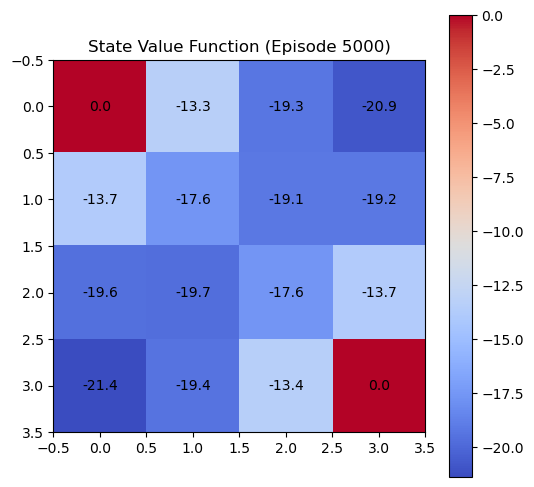

In [13]:
def plot_value_function(V, size=4, episode=0):
    plt.figure(figsize=(6, 6))
    plt.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{V[i, j]:.1f}", ha='center', va='center', color='black')
    plt.title(f"State Value Function (Episode {episode})")
    plt.colorbar()
    plt.show()


def animate_value_function(value_snapshots):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(value_snapshots[0], cmap='coolwarm', interpolation='nearest')
    ax.set_title("State Value Function Evolution")

    def update(frame):
        im.set_array(value_snapshots[frame])
        ax.set_title(f"State Value Function (Episode {frame+1})")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(value_snapshots), interval=200)
    
    ani.save("monte_carlo_evolution.mp4", writer="ffmpeg", fps=10)


N = 5_000

# Run Monte Carlo Policy Evaluation
env = GridWorld()
V, value_snapshots = first_visit_mc_prediction(env, uniform_random_policy, num_episodes=N, gamma=1.0)
plot_value_function(value_snapshots[-1], env.size, N)

# Animate the value function evolution
#animate_value_function(value_snapshots)